In [1]:
# -*- coding: utf-8 -*-
"""
Toxicity Progression Analysis

This script analyzes the progression of toxicity in conversations, utilizing transformers for sequence classification
and visualization tools to understand trends. It supports data preprocessing, feature engineering, model training,
and evaluation.

Author: Suvro Mukherjee
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, logging
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from wordcloud import WordCloud
import seaborn as sns
from tqdm import tqdm

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# ================
# Data Preparation
# ================
# Load dataset
talk_df = pd.read_csv('compiled_data.csv')

talk_df['datetime'] = pd.to_datetime(talk_df['timestamp'], unit='s')
talk_df['hour'] = talk_df['datetime'].dt.hour
talk_df['day'] = talk_df['datetime'].dt.dayofweek

# Define time of day categories
time_bins = [0, 6, 12, 18, 24]
time_labels = ['Night', 'Morning', 'Afternoon', 'Evening']
talk_df['time_of_day'] = pd.cut(talk_df['hour'], bins=time_bins, labels=time_labels, right=False)


In [8]:
# Pre-processing and feature engineering
talk_df = talk_df.sort_values(by = ['conversation_id', 'timestamp'], ascending = True)
talk_df = talk_df.dropna(subset=['Toxicity'])

# Check the total length of the dataset
print(f"Total dataset length: {len(talk_df)}")

# Check the distribution of the dataset across the 'split' feature
split_distribution = talk_df['split'].value_counts()

# Print the distribution
print("\nDataset distribution across splits:")
print(split_distribution)

Total dataset length: 6363

Dataset distribution across splits:
split
train    3857
val      1270
test     1236
Name: count, dtype: int64


In [9]:
# Label encoding for 'Comment Nature'
comment_nature_one_hot = pd.get_dummies(talk_df['Comment Nature'], prefix="nature")
talk_df = pd.concat([talk_df, comment_nature_one_hot], axis=1)

# List the one-hot encoded columns
comment_nature_columns = [col for col in talk_df.columns if col.startswith('nature_')]

threshold = 0.5
high_toxicity_weight = 2.0
low_toxicity_weight = 1.0

# Assign weights: higher weight for toxicity scores greater than threshold
talk_df['weights'] = talk_df['Toxicity'].apply(lambda x: high_toxicity_weight if x > threshold else low_toxicity_weight)

# output_file = 'processed_data.csv'
# talk_df.to_csv(output_file, index=False)
# print(f"Processed data saved to {output_file}")

In [10]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("GPU is available!")
    print("Device Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available. Using CPU.")

GPU is available!
Device Name: Tesla T4


In [11]:
# ================
# Model Definition
# ================
class ToxicityDataset(Dataset):
    def __init__(self, tokens, labels, comment_nature_features, weights):
        self.tokens = tokens
        self.labels = labels
        self.comment_nature_features = comment_nature_features
        self.weights = weights

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.tokens.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        item['comment_nature_features'] = torch.tensor(self.comment_nature_features[idx], dtype=torch.float)
        item['weights'] = torch.tensor(self.weights[idx], dtype=torch.float)
        return item

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (793 > 512). Running this sequence through the model will result in indexing errors


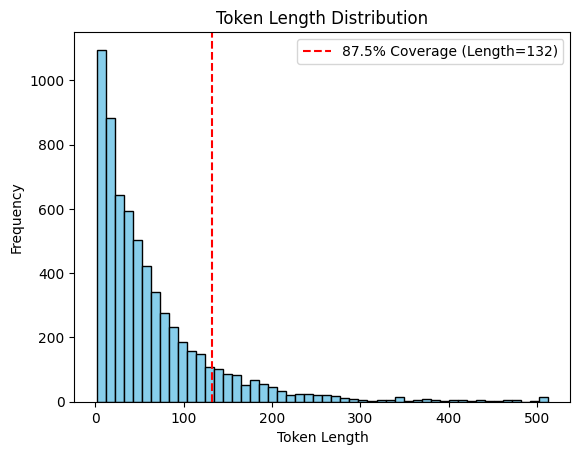

In [31]:
# Choose Base Model
model_name = 'bert-base-uncased'
# model_name = 'roberta-base'
# model_name = 'distilbert-base-uncased'
# model_name = 'microsoft/deberta-base'
# model_name = 'xlnet-base-cased'

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Get token lengths, capping at 512
tokenized_lengths = [min(len(tokenizer.encode(text, truncation=False)), 512) for text in talk_df['text']]

# Sort and find the 90% cutoff
sorted_lengths = np.sort(tokenized_lengths)
percentile = 87.5
cutoff_index = int(len(sorted_lengths) * (percentile / 100))
cutoff_length = sorted_lengths[cutoff_index]

# Plot the histogram
plt.hist(tokenized_lengths, bins=50, color='skyblue', edgecolor='black')
plt.axvline(cutoff_length, color='red', linestyle='--', label=f'{percentile}% Coverage (Length={cutoff_length})')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Token Length Distribution')
plt.legend()
plt.show()

In [32]:
# Tokenize the 'text' field for all splits
def tokenize_data(data, tokenizer,  max_length=135):
    texts = data['text'].astype(str).tolist()
    return tokenizer(
        list(data['text']),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

def prepare_data(data, tokenizer, additional_features, max_length = 135):
  tokens = tokenize_data(data, tokenizer, max_length)
  labels = data['Toxicity'].values
  features = data[additional_features].values
  weights = data['weights'].values
  return ToxicityDataset(tokens, labels, features, weights)


# Split into train, validation, and test based on 'split' column
train_df = talk_df[talk_df['split'] == 'train']
val_df = talk_df[talk_df['split'] == 'val']
test_df = talk_df[talk_df['split'] == 'test']

# Prepare datasets
train_dataset = prepare_data(train_df, tokenizer, comment_nature_columns)
val_dataset = prepare_data(val_df, tokenizer, comment_nature_columns)
test_dataset = prepare_data(test_df, tokenizer, comment_nature_columns)

In [33]:
bilstm = False
class CustomToxicityModel(nn.Module):
    def __init__(self, model_name, num_comment_nature_features):
        super(CustomToxicityModel, self).__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(self.transformer.config.hidden_size + num_comment_nature_features, 1)

    def forward(self, input_ids, attention_mask, comment_nature_features):
        transformer_output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = transformer_output.last_hidden_state[:, 0, :]  # CLS token
        cls_embedding = self.dropout(cls_embedding)
        combined = torch.cat((cls_embedding, comment_nature_features), dim=1)
        output = self.fc(combined)
        return output


In [ ]:
bilstm = True
class BERT_BiLSTM(nn.Module):
    def __init__(self, bert_model, hidden_dim, num_labels, num_comment_nature_features):
        super(BERT_BiLSTM, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.25)
        # BiLSTM layer
        self.lstm = nn.LSTM(input_size=768,  # BERT hidden size
                            hidden_size=hidden_dim,
                            num_layers=1,
                            bidirectional=True,
                            batch_first=True)

        # Fully connected layer: concatenates BiLSTM output and additional features
        self.fc = nn.Linear(hidden_dim * 2 + num_comment_nature_features, num_labels)  # Concatenate

    def forward(self, input_ids, attention_mask, comment_nature_features):
        # BERT forward pass
        bert_output = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = bert_output.last_hidden_state

        # BiLSTM forward pass
        lstm_output, (hn, cn) = self.lstm(sequence_output)
        lstm_output = lstm_output[:, -1, :]  # Take the last token's output

        # Concatenate comment nature features
        concatenated_features = torch.cat((lstm_output, comment_nature_features), dim=1)

        # Fully connected layer
        logits = self.fc(concatenated_features)

        return logits

In [34]:
# Initialize model
num_comment_nature_features = len(comment_nature_columns)
if bilstm:
  hidden_dim = 128  # Size of LSTM hidden layer
  model = BERT_BiLSTM(bert_model=model_name, hidden_dim=hidden_dim, num_labels=1,  num_comment_nature_features=num_comment_nature_features)
else:
  model = CustomToxicityModel(model_name, num_comment_nature_features)

# Move model to current device
model.to(device)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [35]:
# Define lists to store logs
training_logs = {
    "epoch": [],
    "train_loss": [],
    "val_loss": []
}

num_epochs = 5
best_val_loss = float('inf')
patience = 3

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        # Move to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        weights = batch['weights'].to(device)
        comment_nature_features = batch['comment_nature_features'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, comment_nature_features=comment_nature_features)
        loss = criterion(outputs.squeeze(-1), labels)
        weighted_loss = (loss * weights).mean()

        # Backward pass
        weighted_loss.backward()
        optimizer.step()

        total_train_loss += weighted_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            weights = batch['weights'].to(device)
            comment_nature_features = batch['comment_nature_features'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, comment_nature_features=comment_nature_features)
            loss = criterion(outputs.squeeze(-1), labels)

            # Compute loss
            weighted_loss = (loss * weights).mean()
            val_loss += weighted_loss.item()

    avg_val_loss = val_loss / len(val_loader)
    # Store metrics
    training_logs["epoch"].append(epoch + 1)
    training_logs["train_loss"].append(avg_train_loss)
    training_logs["val_loss"].append(avg_val_loss)

    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss}")
    # Early Stopping Logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        epochs_without_improvement = 0
        print(f"Validation loss improved. Saving model at epoch {epoch + 1}.")
    else:
        epochs_without_improvement += 1
        print(f"No improvement in validation loss for {epochs_without_improvement} epochs.")

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        break

# Load the best model state before exiting
model.load_state_dict(best_model_state)
print("Training stopped. Best model loaded.")

100%|██████████| 242/242 [01:30<00:00,  2.66it/s]


Epoch 1, Train Loss: 0.0535
Epoch 1, Validation Loss: 0.02128927831654437
Validation loss improved. Saving model at epoch 1.


100%|██████████| 242/242 [01:30<00:00,  2.67it/s]


Epoch 2, Train Loss: 0.0295
Epoch 2, Validation Loss: 0.017540314787765965
Validation loss improved. Saving model at epoch 2.


100%|██████████| 242/242 [01:30<00:00,  2.68it/s]


Epoch 3, Train Loss: 0.0212
Epoch 3, Validation Loss: 0.0163704764097929
Validation loss improved. Saving model at epoch 3.


100%|██████████| 242/242 [01:30<00:00,  2.68it/s]


Epoch 4, Train Loss: 0.0175
Epoch 4, Validation Loss: 0.015582589138648472
Validation loss improved. Saving model at epoch 4.


100%|██████████| 242/242 [01:30<00:00,  2.68it/s]


Epoch 5, Train Loss: 0.0145
Epoch 5, Validation Loss: 0.014987294127058704
Validation loss improved. Saving model at epoch 5.
Training stopped. Best model loaded.


In [36]:
import json

# Save logs to a JSON file
with open(f"training_logs(Model: {model_name}).json", "w") as f:
    json.dump(training_logs, f)

In [37]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in dataloader:
            # Move data to GPU/CPU
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            weights = batch['weights'].to(device)
            comment_nature_features = batch['comment_nature_features'].to(device)

            # Make predictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, comment_nature_features=comment_nature_features)
            predictions = outputs.squeeze(-1).cpu().numpy()

            # Collect predictions and labels
            all_predictions.extend(predictions)
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    mae = mean_absolute_error(all_labels, all_predictions)
    mse = mean_squared_error(all_labels, all_predictions)
    r2 = r2_score(all_labels, all_predictions)

    return mae, mse, r2, all_predictions, all_labels

# Test evaluation
mae, mse, r2, predictions, labels = evaluate_model(model, test_loader, device)

print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test R² Score: {r2:.4f}")

Test MAE: 0.0615
Test MSE: 0.0127
Test R² Score: 0.7349


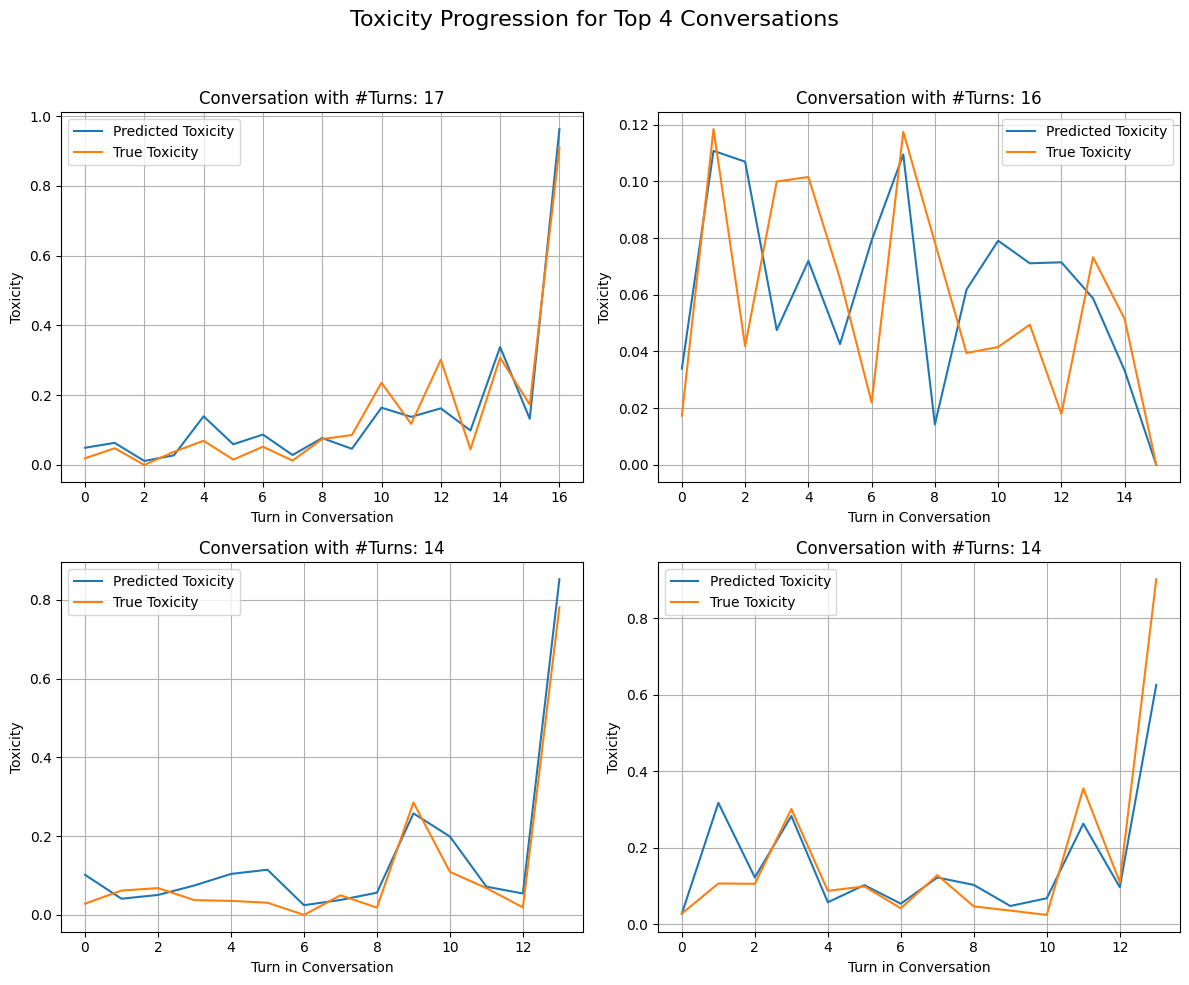

In [ ]:
# Visualize the predicted toxicity progression for the top 4 engaging conversations in test data
highest_comments = test_df['conversation_id'].value_counts().nlargest(4).index

# Set up the plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Toxicity Progression for Top 4 Conversations', fontsize=16)

# Flatten the axes for easy iteration
axes = axes.flatten()

# Iterate through the top 4 conversation IDs and plot
for idx, conversation_id in enumerate(highest_comments):
    # Filter the conversation's DataFrame
    conversation_df = test_df[test_df['conversation_id'] == conversation_id]

    # Tokenize data and prepare DataLoader
    # conversation_tokens = tokenize_data(conversation_df, tokenizer)
    conversation_dataset = prepare_data(conversation_df, tokenizer, comment_nature_columns)
    conversation_loader = DataLoader(conversation_dataset, batch_size=1)

    # Generate predictions for toxicity
    predictions = []
    model.eval()
    with torch.no_grad():
        for batch in conversation_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            comment_nature_features = batch['comment_nature_features'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, comment_nature_features=comment_nature_features)
            predictions.extend(outputs.squeeze(-1).cpu().numpy())

    # Plot the toxicity progression
    axes[idx].plot(range(len(predictions)), predictions, label='Predicted Toxicity')
    axes[idx].plot(range(len(conversation_df)), conversation_df['Toxicity'], label='True Toxicity')
    axes[idx].set_title(f'Conversation with #Turns: {len(conversation_df)}')
    axes[idx].set_xlabel('Turn in Conversation')
    axes[idx].set_ylabel('Toxicity')
    axes[idx].legend()
    axes[idx].grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()